# 냘짜별 네이버증권 주요뉴스 불러오고, 키워드 보여주는 프로그램 

In [15]:
## 네이버증권 주요뉴스 크롤러 + 뉴스 제목과 본문의 키워드까지 출력!

import requests
from bs4 import BeautifulSoup
from collections import Counter
import re
import pandas as pd
from konlpy.tag import Okt

# 특정 페이지의 뉴스를 가져오는 함수
def get_news_from_page(page_url):
    response = requests.get(page_url)  # 페이지 URL로 GET 요청
    response.raise_for_status()  # 요청이 성공하지 않으면 예외 발생
    
    soup = BeautifulSoup(response.text, 'html.parser')  # 페이지 HTML을 파싱
    news_section = soup.find('ul', class_='newsList')  # 뉴스 리스트 섹션을 찾음
    if news_section is None:
        print(f"No news section found on {page_url}")
        return []
    
    news_items = news_section.find_all('li')  # 뉴스 아이템들을 모두 찾음
    
    news_list = []
    for item in news_items:
        title_tag = item.find('dd', class_='articleSubject').find('a')  # 각 뉴스 아이템의 제목 태그를 찾음
        if title_tag is None:
            print(f"No title tag found in item: {item}")
            continue
        
        title = title_tag.get_text(strip=True)  # 제목 텍스트를 가져옴
        if not title:
            print(f"Empty title found in item: {item}")
            continue

        link = "https://finance.naver.com" + title_tag.get('href', '')
        if not link:
            print(f"No link found in item: {item}")
            continue

        summary_tag = item.find('dd', class_='articleSummary')
        summary = summary_tag.get_text(strip=True) if summary_tag else ""
        
        news_list.append({'title': title, 'link': link, 'summary': summary})  # 뉴스 리스트에 추가
    
    return news_list  # 뉴스 리스트를 반환

# 마지막 페이지 번호를 가져오는 함수
def get_last_page_number(date):
    url = f"https://finance.naver.com/news/mainnews.naver?date={date}"
    response = requests.get(url)  # 메인 뉴스 페이지로 GET 요청
    response.raise_for_status()  # 요청이 성공하지 않으면 예외 발생
    
    soup = BeautifulSoup(response.text, 'html.parser')  # 페이지 HTML을 파싱
    page_nav = soup.find('table', class_='Nnavi')  # 페이지 내비게이션 섹션을 찾음

    if page_nav is None:
        return 1  # 페이지 내비게이션이 없으면 첫 페이지로 간주
    
    page_links = page_nav.find_all('a', href=True)  # 페이지 링크들을 모두 찾음
    page_numbers = []
    
    for link in page_links:
        href = link['href']
        if 'page=' in href:
            try:
                page_number = int(href.split('page=')[-1])  # 페이지 번호를 추출
                page_numbers.append(page_number)
            except ValueError:
                continue
    
    if not page_numbers:
        return 1  # 페이지 번호가 없으면 첫 페이지로 간주

    return max(page_numbers)  # 가장 큰 페이지 번호를 반환

# 모든 뉴스를 가져오는 함수
def get_all_news(date):
    base_url = f"https://finance.naver.com/news/mainnews.naver?date={date}&page="
    last_page_number = get_last_page_number(date)  # 마지막 페이지 번호를 가져옴
    
    all_news = []
    for page in range(1, last_page_number + 1):  # 1번 페이지부터 마지막 페이지까지 반복
        page_url = base_url + str(page)  # 각 페이지 URL 생성
        news_list = get_news_from_page(page_url)  # 해당 페이지의 뉴스 목록 가져오기
        all_news.extend(news_list)  # 전체 뉴스 목록에 추가
    
    return all_news  # 모든 뉴스 목록 반환


# 불용어 처리
stopwords = ['.', '(', ')', ',', "'", '%', '-', 'X', ').', '×','의','자','에','안','번','호','을','이','다','만','로','가','를',
             '경제', '증시', '투자', '증권', '증시', '주가', '최고', '발표', '올해', '지난해', '국내', '최근', '최대', '종목', '현지', '가격', '가운데', '시간',
             '관련', '거래', '결제', '소식', '대해', '하루', '오전', '오후', '다시', '이후', '이전',
             '이데일리', '헤럴드경제', '연합뉴스', '파이낸셜뉴스', '매일경제', '머니투데이',
             "and", "are", "is", "the", "a", "an", "in", "on", "of"
             ]

# 사용자 정의 복합 명사 리스트
custom_compound_nouns = ['인공지능', '자연어처리', '딥러닝', '머신러닝', '데이터사이언스']

# 텍스트에서 복합 명사를 인식하고 결합
def combine_compound_nouns(text, compound_nouns):
    for noun in compound_nouns:
        text = text.replace(noun, noun.replace(" ", "_"))
    return text

# 자주 등장하는 키워드를 분석하는 함수
def analyze_keywords(news_list):

    okt = Okt()
    text = " ".join([item['title'] + " " + item['summary'] for item in news_list])
    
    # 한국어 명사 추출
    korean_words = okt.nouns(text)
    # 영어 단어 추출
    english_words = re.findall(r'\b[a-zA-Z]+\b', text)
    # 한국어 명사와 영어 단어 합치기
    all_words = korean_words + english_words
    
    # 불용어 제거 및 필터링
    filtered_words = [word for word in all_words if word not in stopwords and len(word) > 1 and not word.isdigit()]

    # 단어 빈도 계산
    counter = Counter(filtered_words)
    common_words = counter.most_common(50)  # 상위 50개의 자주 등장하는 단어 추출

    return common_words

# 메인 실행 블록
if __name__ == "__main__":
    date = input("Enter the date in YYYY-MM-DD format: ")
    daily_all_news = get_all_news(date)  # 모든 뉴스 가져오기
    news_df = pd.DataFrame(daily_all_news)  # 뉴스 데이터를 DataFrame으로 저장
    
    '''
    # DataFrame을 CSV 파일로 저장
    csv_filename = f'naver_news_{date}.csv'
    news_df.to_csv(csv_filename, index=False, encoding='utf-8')
    print(f"Saved news data to '{csv_filename}'")
    '''
    
    # 자주 등장하는 키워드 분석
    keywords = analyze_keywords(daily_all_news)
    print("\nMost common keywords:")
    for word, count in keywords:
        print(f"{word}: {count}")
    
    if not news_df.empty:
        print("\nSample news articles:")
        for idx, row in news_df.head().iterrows():  # 첫 5개의 기사를 출력해봄
            print(f"{idx + 1}. {row['title']}")
            print(f"   Link: {row['link']}")
            print(f"   Summary: {row['summary']}")
    else:
        print("No news articles found.")


Most common keywords:
미국: 27
한국: 23
시장: 23
뉴욕증시: 22
실적: 22
하락: 19
상장: 17
비트코인: 16
지수: 15
개미: 14
밸류업: 14
테슬라: 14
FOMC: 14
기업: 13
하이브: 13
연방: 12
상승: 12
은행: 12
매수: 12
펀드: 12
가이드라인: 12
ETF: 12
확대: 11
글로벌: 11
장사: 11
공매도: 10
투자자: 10
서울: 10
금융: 10
대표: 10
공개시장: 9
위원회: 9
결과: 9
증가: 9
불법: 9
깜짝: 9
코스피: 9
어닝: 9
서프라이즈: 9
지속: 8
전망: 8
금감원: 8
우려: 8
조선: 8
비즈: 8
일제: 8
사업: 7
개인: 7
정부: 7
금리인하: 7

Sample news articles:
1. 뉴욕증시, 파월 기자회견 기다리며 혼조 출발
   Link: https://finance.naver.com/news/news_read.naver?article_id=0014664305&office_id=001&mode=mainnews&type=&date=2024-05-01&page=1
   Summary: 정선영 연합인포맥스 특파원 = 뉴욕증시는 미국 연방공개시장위원회(FOMC) 결과를 기다리며 혼조세를 보였다. 제롬 파월 미국 연방준비제..연합뉴스|2024-05-01 23:59:20
2. 뉴욕증시, FOMC 대기하며 혼조세…파월 '매의 발톱' 세울 듯
   Link: https://finance.naver.com/news/news_read.naver?article_id=0005413096&office_id=277&mode=mainnews&type=&date=2024-05-01&page=1
   Summary: 미국 뉴욕증시의 3대 지수는 이달 첫 거래일인 1일(현지시간) 장 초반 보합권에서 혼조세를 나타내고 있다. 이날 연방공개시장위원회(FO..아시아경제|2024-05-01 23:04:37
3. 월마트, 수익성 부족으로 미국 내 모든 진료소 폐쇄


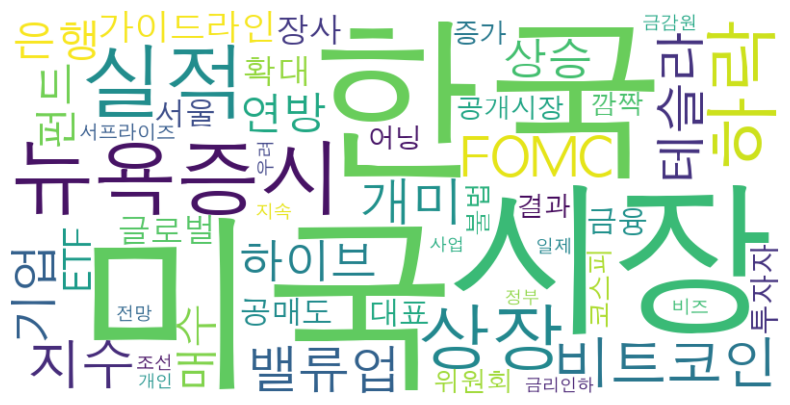

In [16]:
## 단어구름으로 시각화

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 단어 구름 생성을 위해 딕셔너리 형태로 변환
word_freq_dict = dict(keywords)

# WordCloud 객체 생성
wordcloud = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf',  # 한글 폰트 경로
                      width=800, 
                      height=400, 
                      background_color='white').generate_from_frequencies(word_freq_dict)

# 단어 구름 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.show()

# 검색어를 통해 기업뉴스를 읽는 프로그램

[2024-05-22 15:31:36.258683] Url Request Success
[2024-05-22 15:31:36.514979] Url Request Success
[2024-05-22 15:31:36.678848] Url Request Success
[2024-05-22 15:31:36.859541] Url Request Success
[2024-05-22 15:31:37.041153] Url Request Success
[2024-05-22 15:31:37.215687] Url Request Success
[2024-05-22 15:31:37.383347] Url Request Success
[2024-05-22 15:31:37.690194] Url Request Success
[2024-05-22 15:31:37.889608] Url Request Success
[2024-05-22 15:31:38.136941] Url Request Success
HTTP Error 400: Bad Request
[2024-05-22 15:31:38.228257] Error for URL : https://openapi.naver.com/v1/search/news.json?query=%EC%97%94%EB%B9%84%EB%94%94%EC%95%84&start=1001&display=100
전체 검색 : 191035 건
가져온 데이터 : 1000 건


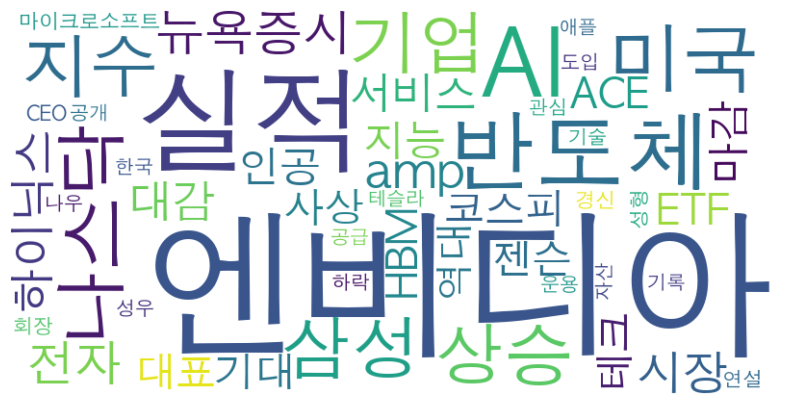

In [41]:
import os
import sys
import urllib.request
import datetime
import time
import json
import ssl

import re
import pandas as pd
from collections import Counter
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt


## 네이버 API --> 따로 발급받아서 써야 함
client_id = "id"
client_secret = "secret"


def getRequestUrl(url):
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_secret)

    context = ssl._create_unverified_context()

    try:
        response = urllib.request.urlopen(req, context=context)
        if response.getcode() == 200:
            print("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None


def getNaverSearch(node, srcText, start, display):
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(srcText), start, display)

    url = base + node + parameters
    responseDecode = getRequestUrl(url)  

    if responseDecode is None:
        return None
    else:
        return json.loads(responseDecode)


def getPostData(post, jsonResult, cnt):
    title = post['title']
    description = post['description']
    org_link = post['originallink']
    link = post['link']

    pDate = datetime.datetime.strptime(post['pubDate'], '%a, %d %b %Y %H:%M:%S +0900')
    pDate = pDate.strftime('%Y-%m-%d %H:%M:%S')

    jsonResult.append({'cnt': cnt, 'title': title, 'description': description,
                       'org_link': org_link, 'link': link, 'pDate': pDate})
    return


def Crawling_json():
    node = 'news'  
    srcText = input('검색어를 입력하세요: ')
    cnt = 0
    jsonResult = []

    jsonResponse = getNaverSearch(node, srcText, 1, 100)  
    if jsonResponse is None:
        print("No response received. Exiting.")
        return

    total = jsonResponse.get('total', 0)

    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):
        for post in jsonResponse['items']:
            cnt += 1
            getPostData(post, jsonResult, cnt)  

        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = getNaverSearch(node, srcText, start, 100) 

    print('전체 검색 : %d 건' % total)

    ## 크롤링한 데이터의 json파일
    jsonFile = json.dumps(jsonResult, indent=4, sort_keys=True, ensure_ascii=False)

    print("가져온 데이터 : %d 건" % (cnt))
    #print('%s_naver_%s.json SAVED' % (srcText, node))

    return jsonFile, srcText, node, jsonResult

# 뉴스기사 json형태로 저장
def Save_json(jsonFile, srcText, node, jsonResult):
    with open('%s_naver_%s.json' % (srcText, node), 'w', encoding='utf8') as outfile:
        jsonFile = json.dumps(jsonResult, indent=4, sort_keys=True, ensure_ascii=False)
        outfile.write(jsonFile)

# DataFrame 상태에서 wordkeyword까지
def DataFrame_list(jsonFile):
    # Load JSON data -> Convert to DataFrame
    data = json.loads(jsonFile)
    search_df = pd.DataFrame(data)

    # 리스트화
    news_list = search_df[['title', 'link', 'description']].to_dict(orient='records')

    return news_list

# 불용어 처리
stopwords = ['.', '(', ')', ',', "'", '%', '-', 'X', ').', '×', 'quot', '<b>', '</b>',
             '의','자','에','안','번','호','을','이','다','만','로','가','를',
             '경제', '증시', '투자', '증권', '증시', '주가', '최고', '발표', '올해', '지난해', '국내', '최근', '최대', '종목', '현지', '가격', '가운데', '시간',
             '관련', '거래', '결제', '소식', '대해', '하루', '오전', '오후', '다시', '이후', '이전',
             '이데일리', '헤럴드경제', '연합뉴스', '파이낸셜뉴스', '매일경제', '머니투데이',
             "and", "are", "is", "the", "a", "an", "in", "on", "of"
             ]

# 사용자 정의 복합 명사 리스트
custom_compound_nouns = ['인공지능', '자연어처리', '딥러닝', '머신러닝', '데이터사이언스']

# 자주 등장하는 키워드를 분석하는 함수
def analyze_keywords(news_list):

    okt = Okt()
    text = " ".join([item['title'] + " " + item['description'] for item in news_list])
    
    # 한국어 명사 추출
    korean_words = okt.nouns(text)
    # 영어 단어 추출
    english_words = re.findall(r'\b[a-zA-Z]+\b', text)
    # 한국어 명사와 영어 단어 합치기
    all_words = korean_words + english_words
    
    # 불용어 제거 및 필터링
    filtered_words = [word for word in all_words if word not in stopwords and len(word) > 1 and not word.isdigit()]

    # 단어 빈도 계산
    counter = Counter(filtered_words)
    common_words = counter.most_common(50)  # 상위 50개의 자주 등장하는 단어 추출

    return common_words

def wordcloud_display(keywords):
    word_freq_dict = dict(keywords)
    wordcloud = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf',
                          width=800, height=400,
                          background_color='white').generate_from_frequencies(word_freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    jsonFile, srcText, node, jsonResult = Crawling_json()
    
    #Save_json(jsonFile, srcText, node, jsonResult)

    news_list = DataFrame_list(jsonFile)
    keywords = analyze_keywords(news_list)

    wordcloud_display(keywords) 
